<a href="https://colab.research.google.com/github/liel-cohen/tcrdist_KNN/blob/main/tcrdist3_for_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K Nearest Neighbour Classification using tcrdist3**

 
#### Background 

*   The analysis in this notebook was contributed by Machine Learning researcher
and Ph.D. Candidate Liel Cohen-Lavi (Hertz Lab,  Ben Gurion University of the Negev). 
* The code uses tcrdist3 a Python package explained in more detail in *Mayer-Blackwell et al., eLife* [2022](https://elifesciences.org/articles/68605) and in a recent Spring Protocols book chapter ** Flexible Distance-Based 
TCR Analysis in Python with tcrdist3*, [2022](https://link.springer.com/protocol/10.1007/978-1-0716-2712-9_16). Additional documentation can be found at [tcrdist3.readthedocs.io](https://tcrdist3.readthedocs.io/en/latest/).

#### Notebook Outline 

This notebook contains two separate, standalone examples for training a K Nearest Neighbour classifier using tcrdist as a distance metric, to classify epitope-specific TCRs to their epitope.
* **Example 1: cross-validation model estimation.** We estimate the model's performance using cross-validation on a single dataset. The Dash paired-TCR dataset is used in this example.
* **Example 2: train & test datasets.** We train the classifier on a training dataset, then test on an independent test dataset. The datasets used in this example were downloaded from https://github.com/IdoSpringer/ERGO-II/.

The tcdrdist3 package (https://tcrdist3.readthedocs.io/en/latest/index.html) is used to compute tcrdist distance. The code allows using human or mouse TCRs, using CDR3 only or all CDRs (extracted from given v-genes by tcrdist3 code), and using a single chain or both chains. It tests the models and creates plots visualizing the results using several performance metrics.

We hope this will be helpful.

## Installations and Imports

In [ ]:
%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kmayerb/tcrdist3.git (to revision 0.2.2) to /tmp/pip-req-build-0f0ya4a0
  Running command git clone -q https://github.com/kmayerb/tcrdist3.git /tmp/pip-req-build-0f0ya4a0
  Running command git checkout -q 04b0b8c2573d04a9d2cb77f7a3aeeed3a0eab167


In [ ]:
from tcrdist.repertoire import TCRrep
import pwseqdist as pw

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

# **Example 1: Cross-Validation Model Estimation**

#### The [Dash et al., 2017](https://www.nature.com/articles/nature22383) paired-TCR dataset (mouse only) is used in this example. We  estimate the model's performance using cross-validation on a single dataset. 

### Parameters

Here we define some parameter variables.

In [ ]:
# <k_cv> - number of cross-validation folds
k_cv = 5         
# <k_neighbours> -  number of neighbours for KNN
k_neighbours = 5  
# <organism> - tcrdist3 accepts 'mouse' or 'human'
organism = 'mouse'
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha', 'beta'] 
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will 
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all' 

check that user-input parameters are valid

In [ ]:
# make sure input config params are valid
assert isinstance(k_cv, int)
assert isinstance(k_neighbours, int)
assert organism=='mouse' or organism=='human'
assert cdrs=='all' or cdrs=='cdr3'
assert chains==['alpha', 'beta'] or chains==['beta', 'alpha'] or chains==['alpha'] or chains==['beta']

### Load the Dash et al., 2017 mouse data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/kmayerb/tcrdist3/master/dash.csv")
print('df.columns:', list(df.columns))
df.head()

df.columns: ['subject', 'epitope', 'count', 'v_a_gene', 'j_a_gene', 'cdr3_a_aa', 'cdr3_a_nucseq', 'v_b_gene', 'j_b_gene', 'cdr3_b_aa', 'cdr3_b_nucseq', 'clone_id']


,subject,epitope,count,v_a_gene,j_a_gene,cdr3_a_aa,cdr3_a_nucseq,v_b_gene,j_b_gene,cdr3_b_aa,cdr3_b_nucseq,clone_id
0,mouse_subject0050,PA,2,TRAV7-3*01,TRAJ33*01,CAVSLDSNYQLIW,tgtgcagtgagcctcgatagcaactatcagttgatctgg,TRBV13-1*01,TRBJ2-3*01,CASSDFDWGGDAETLYF,tgtgccagcagtgatttcgactggggaggggatgcagaaacgctgt...,mouse_tcr0072.clone
1,mouse_subject0050,PA,6,TRAV6D-6*01,TRAJ56*01,CALGDRATGGNNKLTF,tgtgctctgggtgacagggctactggaggcaataataagctgactttt,TRBV29*01,TRBJ1-1*01,CASSPDRGEVFF,tgtgctagcagtccggacaggggtgaagtcttcttt,mouse_tcr0096.clone
2,mouse_subject0050,PA,1,TRAV6D-6*01,TRAJ49*01,CALGSNTGYQNFYF,tgtgctctgggctcgaacacgggttaccagaacttctatttt,TRBV29*01,TRBJ1-5*01,CASTGGGAPLF,tgtgctagcacagggggaggggctccgcttttt,mouse_tcr0276.clone
3,mouse_subject0050,PA,2,TRAV6-4*01,TRAJ34*02,CALAPSNTNKVVF,tgtgctctggccccttccaataccaacaaagtcgtcttt,TRBV2*01,TRBJ2-7*01,CASSQDPGDYEQYF,tgtgccagcagccaagatcctggggactatgaacagtacttc,mouse_tcr0269.clone
4,mouse_subject0050,PA,1,TRAV6-4*01,TRAJ34*02,CALVPSNTNKVVF,tgtgctctggtcccttccaataccaacaaagtcgtcttt,TRBV29*01,TRBJ2-4*01,CASSLGGENTLYF,tgtgctagcagtttagggggggaaaacaccttgtacttt,mouse_tcr0285.clone


In [ ]:
n_orig = df.shape[0]
print(f'The dataset contains {df.shape[0]} TCRs for {len(df["epitope"].unique())} different epitopes. The amount of TCRs per epitope:\n')
df['epitope'].value_counts()

The dataset contains 1924 TCRs for 7 different epitopes. The amount of TCRs per epitope:



PB1     642
PA      324
NP      305
M45     291
M38     158
F2      117
m139     87
Name: epitope, dtype: int64

#### Drop duplicates TCRs

We want to avoid TCRs that are identical with the same epitope specificity from 
influencing our estimate of classifer performance. Thus we identify columns in addition to 'epitope' that define a duplicate TCR.

In [ ]:
# get col names to condiser for dropping duplicate TCRs 
drop_dup_cols = ['epitope']

# add alpha chain col names
if 'alpha' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_a_aa']
elif 'alpha' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']

# add beta chain col names
if 'beta' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_b_aa']
elif 'beta' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']

Drop duplicate TCRs for each epitope separately

In [ ]:
df = df.drop_duplicates(subset=drop_dup_cols, keep='first').copy()
df.reset_index(drop=True, inplace=True)
print(f'Dropped {n_orig - df.shape[0]} duplicate TCRs by columns {drop_dup_cols}.')
print(f'The new amount of TCRs per epitope:\n')
df['epitope'].value_counts()

Dropped 166 duplicate TCRs by columns ['epitope', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene'].
The new amount of TCRs per epitope:



PB1     584
PA      293
M45     271
NP      263
M38     143
F2      117
m139     87
Name: epitope, dtype: int64

### Compute Matrix of pairwise TCR distances between all receptors

*If asked to use all cdrs to compute tcrdist distances, compute it when TCRrep object is initialized. If asked to use only CDR3, the TCRrep object metric parameters need to be altered before computing the distances.

In [ ]:
tr = TCRrep(cell_df=df,
            organism=organism, 
            chains=chains,
            deduplicate=True)

# <X> will be our matrix of distances, which will depend on <chains> and <cdrs>
X = None
if cdrs=='all':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_alpha)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_beta)
if cdrs=='cdr3':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_cdr3_b_aa)
assert X is not None

In [ ]:
Y = tr.clone_df['epitope'].copy() # target labels

In [ ]:
# Make sure X and Y are valid
assert X.shape[0] == X.shape[1], f'assert X shape is nXn: {X.shape[0]} == {X.shape[1]} ?'
#assert X.shape[0] == df.shape[0], f'assert X dimension equals df dimension: {X.shape[0]} == {df.shape[0]} ?'
assert X.shape[0] == Y.shape[0],  f'assert Y length = n: {X.shape[0]} == {Y.shape[0]} ?'

X.index = list(X.index) # change from range to int if needed
Y.index = list(Y.index) # change from range to int if needed
assert (X.index.equals(Y.index)), f'assert X and Y indices are equal' 

### Perform CV

In [ ]:
# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())

# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)

In [ ]:
# Get CV folds
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=1)
kfolds.get_n_splits(X)

# perform CV
for train_ind, test_ind in kfolds.split(X, Y):
    # split data
    X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
    Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

    # train model
    model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
    model.fit(X_train, Y_train.ravel())

    # get predictions
    preds_labels = model.predict(X_test)
    preds_prob = model.predict_proba(X_test)

    # store in df
    preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
    preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

    ###--- calculate performance metrics

    # calculate & store average metrics
    Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

    roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
    accuracy_fold = accuracy_score(Y_test, preds_labels)
    precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
    recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
    
    metrics_cv_df = metrics_cv_df.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                    'Recall': recall_fold, 'Precision': precision_fold}), ignore_index=True)

    # calculate & store AUC per epitope
    roc_auc_epitopes = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average=None)
    auc_cv_df = auc_cv_df.append(pd.Series(roc_auc_epitopes, index=model.classes_), ignore_index=True)

    # calculate & store recall per epitope
    recall_epitopes = recall_score(Y_test, preds_labels, average=None)
    recall_cv_df = recall_cv_df.append(pd.Series(recall_epitopes, index=model.classes_), ignore_index=True)

    # calculate & store recall per epitope
    precision_epitopes = precision_score(Y_test, preds_labels, average=None)
    precision_cv_df = precision_cv_df.append(pd.Series(precision_epitopes, index=model.classes_), ignore_index=True)

metrics_cv_df

,AUC,Accuracy,Recall,Precision
0,0.909178,0.781250,0.740560,0.754827
1,0.906072,0.795455,0.749973,0.775966
2,0.892658,0.767045,0.729005,0.737586
3,0.927754,0.811966,0.760594,0.770379
4,0.928508,0.797721,0.759821,0.774778


### Plot results

Plot confusion matrix (for all folds together)

In [ ]:
# get confusion matrices
epitopes = list(preds_df['y_true'].unique())
conf_mat_dash = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred']), columns=epitopes, index=epitopes)
conf_mat_dash_norm = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred'], normalize='true'), columns=epitopes, index=epitopes)

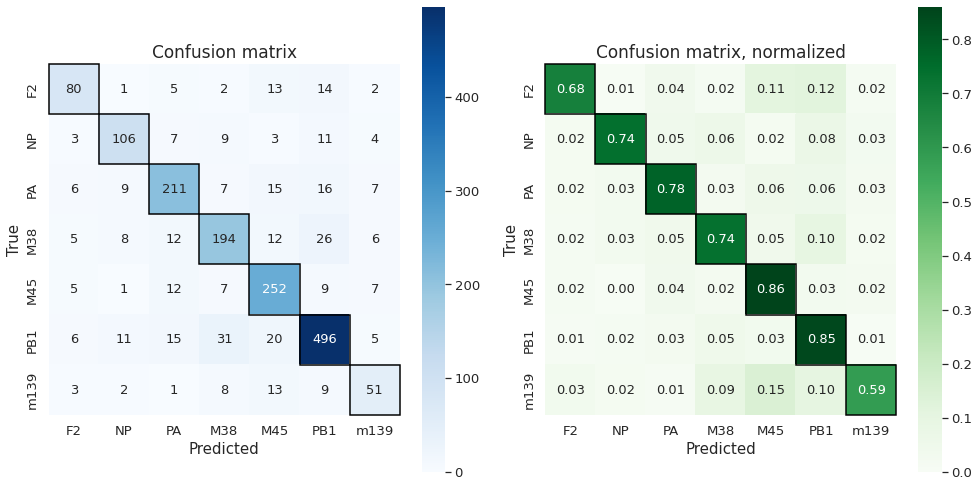

In [ ]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
sns.set_context(font_scale=1.3)
sns.heatmap(conf_mat_dash, annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13}, vmin=0)
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)

sns.heatmap(conf_mat_dash_norm, annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13}, vmin=0)
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)

for epi_ind in range(conf_mat_dash.shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

Plot metrics

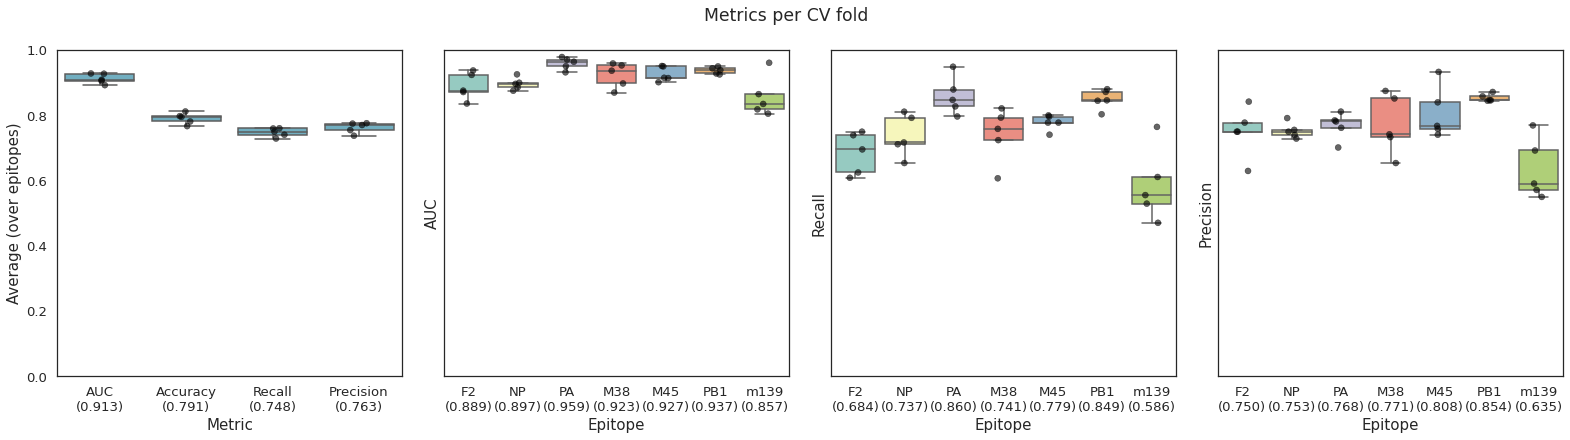

(mean over folds)


In [ ]:
### Plot boxplots
sns.set(font_scale=1.2)
sns.set_style('white')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(27, 6), sharey=True)

# average metrics plot
sns.boxplot(data=metrics_cv_df, ax=axes[0], showfliers=False, color='c')
sns.stripplot(data=metrics_cv_df, ax=axes[0], jitter=0.15, size=6,
                        alpha=0.6,
                        edgecolor='black', linewidth=0.5,
                        color='black')
axes[0].set_xticklabels([metric + f'\n({metrics_cv_df[metric].mean():.3f})' for metric in metrics_cv_df.columns])
axes[0].set_ylabel('Average (over epitopes)', fontsize=15)
axes[0].set_xlabel('Metric', fontsize=15)

# metrics per epitope plots
def plot_metric_per_epitope(metric_df, ax, metric_name):
  sns.boxplot(data=metric_df, ax=ax, showfliers=False, palette='Set3')
  sns.stripplot(data=metric_df, ax=ax, jitter=0.15, size=6,
                          alpha=0.6,
                          edgecolor='black', linewidth=0.5,
                          color='black')
  ax.set_xlabel('Epitope', fontsize=15)
  ax.set_ylabel(f'{metric_name}', fontsize=15)
  ax.set_xticklabels([epi + f'\n({metric_df[epi].mean():.3f})' for epi in metric_df.columns])

plot_metric_per_epitope(auc_cv_df, axes[1], 'AUC')
plot_metric_per_epitope(recall_cv_df, axes[2], 'Recall')
plot_metric_per_epitope(precision_cv_df, axes[3], 'Precision')

# finalize
plt.ylim((0,1))
plt.suptitle('Metrics per CV fold')
plt.subplots_adjust(wspace=0.12)
plt.show() # or plt.savefig('CV_results.jpg', dpi=500, , bbox_inches='tight')

print('(mean over folds)')

# **Example 2: Train & Test Datasets**
#### Train classifier on a train dataset, then test on another, independent test dataset.
The datasets used were downloaded from https://github.com/IdoSpringer/ERGO-II/tree/master/Samples. These are pickle files (vdjdb_no10x_train_samples.pickle, vdjdb_no10x_test_samples.pickle), whcih can be converted into a pandas dataframes and csv files easily. For example:
```python
def load_from_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

df_train = load_from_pickle("vdjdb_no10x_train_samples.pickle")
df_train = pd.DataFrame.from_dict(df_train)
df_train.to_csv("vdjdb_no10x_train_samples.csv", index = False)
```

### Parameters

Set manually

In [ ]:
# set params
k_neighbours = 5
organism = 'human' # 'mouse' or 'human'
chains = ['alpha', 'beta'] # ['alpha', 'beta'] or ['alpha'] or ['beta']
cdrs = 'all' # 'cdr3' or 'all'

validate user-inputs

In [ ]:
# make sure input config params are valid
assert organism=='mouse' or organism=='human'
assert cdrs=='all' or cdrs=='cdr3'
assert chains==['alpha', 'beta'] or chains==['beta', 'alpha'] or chains==['alpha'] or chains==['beta']

In [ ]:
# get col names to condiser for dropping duplicate TCRs 
drop_dup_cols = ['epitope']

# add alpha chain col names
if 'alpha' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_a_aa']
elif 'alpha' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']

# add beta chain col names
if 'beta' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_b_aa']
elif 'beta' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']

## Train

### Prepare training data

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/liel-cohen/tcrdist_KNN/main/vdjdb_no10x_train_samples.csv', index_col=0)

print('df_train.columns:', list(df_train.columns))
df_train.head()

df_train.columns: ['tcra', 'tcrb', 'va', 'ja', 'vb', 'jb', 't_cell_type', 'peptide', 'protein', 'mhc', 'sign']


,tcra,tcrb,va,ja,vb,jb,t_cell_type,peptide,protein,mhc,sign
0,UNK,CAITEGGAHNYEQYF,UNK,UNK,TRBV10-3*01,TRBJ2-7*01,MHCI,GILGFVFTL,M,HLA-A*02:01,0
1,UNK,CASSRQGNSNQPQYF,UNK,UNK,TRBV13*01,TRBJ1-5*01,MHCI,YSEHPTFTSQY,pp65,HLA-A*01:01,0
2,UNK,CATDLSRTSNQPQYF,UNK,UNK,TRBV15*01,TRBJ1-5*01,MHCI,GILGFVFTL,M,HLA-A*02:01,0
3,UNK,CASSLGQAYEQYF,UNK,UNK,TRBV7-8*01,TRBJ2-7*01,MHCI,EPLPQGQLTAY,BZLF1,HLA-B*35:01,0
4,UNK,CASSLYYSRPNTEAFF,UNK,UNK,TRBV5-1*01,TRBJ1-1*01,MHCI,GILGFVFTL,M,HLA-A*02:01,0


Keep only TCRs that have CDR3a and CDR3b, specific to epitope presented on MHC class 1, specifically HLA-A*02

In [ ]:
df_train = df_train.loc[df_train['sign'] == 1]
df_train = df_train.loc[df_train['tcra'] != 'UNK']
df_train = df_train.loc[df_train['mhc'].isin(['HLA-A*02', 'HLA-A*02:01'])]
df_train = df_train.loc[df_train['t_cell_type']=='MHCI']

Make some changes to df_train so it will match tcrdist3 input df format

In [ ]:
# add 'epitope' and 'count' columns
df_train['count'] = 1

# change some column names
df_train.rename(columns={'va': 'v_a_gene', 'ja': 'j_a_gene',
                         'vb': 'v_b_gene', 'jb': 'j_b_gene',
                         'tcra': 'cdr3_a_aa', 'tcrb': 'cdr3_b_aa',
                         'peptide': 'epitope'}, inplace=True)

Drop duplicate TCRs for each epitope *separately*

In [ ]:
n_orig = df_train.shape[0]
print(f'The dataset contains {df_train.shape[0]} TCRs for {len(df_train["epitope"].unique())} different epitopes\n')

The dataset contains 1279 TCRs for 13 different epitopes



In [ ]:
df_train = df_train.drop_duplicates(subset=drop_dup_cols, keep='first').copy()
df_train.reset_index(drop=True, inplace=True)

print(f'Dropped {n_orig - df_train.shape[0]} duplicate TCRs by columns {drop_dup_cols}.')
print(f'The new amount of TCRs per epitope:\n')
df_train['epitope'].value_counts()

Dropped 90 duplicate TCRs by columns ['epitope', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene'].
The new amount of TCRs per epitope:



GILGFVFTL     523
LLWNGPMAV     196
NLVPMVATV     149
GLCTLVAML     127
CINGVCWTV      62
ELAGIGILTV     46
KLVALGINAV     30
KLSALGINAV     20
VAANIVLTV      13
CVNGSCFTV      11
YVLDHLIVV       8
RMFPNAPYL       3
KIFGSLAFL       1
Name: epitope, dtype: int64

Drop epitopes with less than 60 TCRs

In [ ]:
peptide_counts = df_train['epitope'].value_counts()
peptide_list = peptide_counts[peptide_counts >= 60].index
df_train = df_train[df_train['epitope'].isin(peptide_list)]
df_train.reset_index(drop=True, inplace=True)

print(f'The new amount of TCRs per epitope, after dropping epitopes with less than 60 TCRs:\n')
df_train['epitope'].value_counts()

The new amount of TCRs per epitope, after dropping epitopes with less than 60 TCRs:



GILGFVFTL    523
LLWNGPMAV    196
NLVPMVATV    149
GLCTLVAML    127
CINGVCWTV     62
Name: epitope, dtype: int64

In [ ]:
df_train

,cdr3_a_aa,cdr3_b_aa,v_a_gene,j_a_gene,v_b_gene,j_b_gene,t_cell_type,epitope,protein,mhc,sign,count
0,CAGAGGGSQGNLIF,CASSKRSTDTQYF,TRAV27*01,TRAJ42*01,TRBV19*02,TRBJ2-3*01,MHCI,GILGFVFTL,M,HLA-A*02:01,1,1
1,CAGAEGGSQGNLIF,CASSIRSTGELFF,TRAV27*01,TRAJ42*01,TRBV19*01,TRBJ2-2*01,MHCI,GILGFVFTL,M,HLA-A*02:01,1,1
2,CAGPGSNTGKLIF,CASSIRSSYEQYF,TRAV27*01,TRAJ37*01,TRBV19*01,TRBJ2-7*01,MHCI,GILGFVFTL,M,HLA-A*02:01,1,1
3,CAEYSSASKIIF,CASSQSPGGTQYF,TRAV5*01,TRAJ3*01,TRBV14*01,TRBJ2-3*01,MHCI,GLCTLVAML,BMLF1,HLA-A*02:01,1,1
4,CAVTSDKLIF,CASSAGTGAYEQYF,TRAV12-2*01,TRAJ34*01,TRBV9*01,TRBJ2-7*01,MHCI,LLWNGPMAV,NS4B,HLA-A*02:01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1052,CAGGGQGGSQGNLIF,CASSLYSNQPQHF,TRAV27*01,TRAJ42*01,TRBV19*01,TRBJ1-5*01,MHCI,GILGFVFTL,M,HLA-A*02:01,1,1
1053,CAVDVSDRGSTLGRLYF,CASSGTSFTEQYF,TRAV22*01,TRAJ18*01,TRBV19*01,TRBJ2-7*01,MHCI,GILGFVFTL,M,HLA-A*02:01,1,1
1054,CAHGGSQGNLIF,CASSIRSSYEQYF,TRAV12-2*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,MHCI,GILGFVFTL,M,HLA-A*02:01,1,1
1055,CAGAIGSSNTGKLIF,CASSVRSSYEQYF,TRAV27*01,TRAJ37*01,TRBV19*02,TRBJ2-7*01,MHCI,GILGFVFTL,M,HLA-A*02:01,1,1


In [ ]:
tr = TCRrep(cell_df=df_train,
            chains = chains,
            organism=organism, 
            deduplicate=True)

/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:503: UserWarning: nan gene was not recognized in reference db no cdr seq could be inferred
  attr ='cdrs')
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:507: UserWarning: nan gene was not recognized in reference db no cdr seq could be inferred
  attr ='cdrs')
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:511: UserWarning: nan gene was not recognized in reference db no cdr seq could be inferred
  attr ='cdrs')
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.39 of 1057 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()
  self.deduplicate()


### Get tcrdist distances for training data

*If asked to use all cdrs to compute tcrdist distances, can compute it when TCRrep object is initialized. If asked to use only CDR3, the TCRrep object metric parameters need to be altered before computing the distances.

In [ ]:
tr = TCRrep(cell_df=df_train,
            chains = chains,
            organism=organism, 
            deduplicate=True) # This step will remove any TCRs where we could not infer genes

# <X> will be our matrix of distances, which will depend on <chains> and <cdrs>
X = None
if cdrs=='all':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_alpha)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_beta)
if cdrs=='cdr3':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_cdr3_b_aa)

assert X is not None

In [ ]:
Y = pd.DataFrame(tr.clone_df['epitope']) # training data labels

In [ ]:
# Make sure X and Y are valid
assert X.shape[0] == X.shape[1], f'assert X shape is nXn: {X.shape[0]} == {X.shape[1]} ?'
#assert X.shape[0] == df_train.shape[0], f'assert X dimension equals df_train dimension: {X.shape[0]} == {df_train.shape[0]} ?'
assert X.shape[0] == Y.shape[0],  f'assert Y length = n: {X.shape[0]} == {Y.shape[0]} ?'

X.index = list(X.index) # change from range to int
Y.index = list(Y.index) # change from range to int
assert (X.index.equals(Y.index)), f'assert X and Y indices are equal' 

### Train KNN model

In [ ]:
# train model on entire train set
model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance')
model.fit(X, Y.values.ravel())

KNeighborsClassifier(metric='precomputed', weights='distance')

## Test

### Prepare test data

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/liel-cohen/tcrdist_KNN/main/vdjdb_no10x_test_samples.csv', index_col=0)

print('df_test.columns:', list(df_test.columns))
df_test.head()

df_test.columns: ['tcrb', 'tcra', 'va', 'ja', 'vb', 'jb', 'peptide', 'protein', 'mhc', 't_cell_type', 'sign']


,tcrb,tcra,va,ja,vb,jb,peptide,protein,mhc,t_cell_type,sign
0,CASSKQGLGSTNEKLFF,UNK,UNK,UNK,TRBV6-1*01,TRBJ1-4*01,TTPESANL,Tat,Mamu-A*01,MHCI,1
1,CSATTQTLDRRIRTDTQYF,UNK,UNK,UNK,TRBV20-1*01,TRBJ2-3*01,NLVPMVATV,pp65,HLA-A*02,MHCI,0
2,CATSRPVGEYTEAFF,UNK,UNK,UNK,TRBV15*01,TRBJ1-1*01,FLKEKGGL,Nef,HLA-B*08,MHCI,0
3,CASSLAGVGNEQFF,UNK,UNK,UNK,TRBV7-3*01,TRBJ2-1*01,FLGKIWPSHK,Gag,HLA-A*02:01,MHCI,0
4,CATRIGWGTDTQYF,CAVRDTNTNAGKSTF,TRAV1-1*01,NaN,TRBV5-1*01,TRBJ2-3*01,DPFRLLQNSQVFS,NP,HLA-DRA*01,MHCI,0


Keep only TCRs that have CDR3a and CDR3b, specific to epitope presented on MHC class 1, specifically HLA-A*02

In [ ]:
df_test = df_test.loc[df_test['sign'] == 1]
df_test = df_test.loc[df_test['tcra'] != 'UNK']
df_test = df_test.loc[df_test['mhc'].isin(['HLA-A*02', 'HLA-A*02:01'])]
df_test = df_test.loc[df_test['t_cell_type']=='MHCI']

In [ ]:
print(f'Test set contains {df_test.shape[0]} TCRs.')

Test set contains 279 TCRs.


Make some changes to df_test so it will match tcrdist3 input df format

In [ ]:
# add 'count' column
df_test['count'] = 1

# change some column names
df_test.rename(columns={'va': 'v_a_gene', 'ja': 'j_a_gene',
                         'vb': 'v_b_gene', 'jb': 'j_b_gene',
                         'tcra': 'cdr3_a_aa', 'tcrb': 'cdr3_b_aa',
                         'peptide': 'epitope'}, inplace=True)

Keep only epitopes included in the train set

In [ ]:
peptide_list = list(df_train['epitope'].unique())
df_test = df_test.loc[df_test['epitope'].isin(peptide_list)]
df_test.reset_index(drop=True, inplace=True)

### Get tcrdist distances between test TCRs and train TCRs
*If asked to use all cdrs to compute tcrdist distances, compute it when TCRrep object is initialized. If asked to use only CDR3, the TCRrep object metric parameters need to be altered before computing the distances.

In [ ]:
tcrrep_test = TCRrep(cell_df=df_test,
                     organism=organism, 
                     chains=chains,
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df, 
                                    df2=tr.clone_df)

# tcrrep_test = TCRrep(cell_df=df_test,
#                      organism=organism, chains=chains,
#                      compute_distances=False,
#                      deduplicate=False,
#                      infer_all_genes=True if cdrs=='all' else False,
#                      infer_cdrs=True if cdrs=='all' else False)

# assert tcrrep_test.clone_df.index.equals(df_test.index) # make sure no TCRs were dropped

/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.9 of 257 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()
  self.deduplicate()


Get distances matrix (X_test) between test and train TCRs

In [ ]:
if cdrs=='all':
  if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
      X_test = pd.DataFrame(tcrrep_test.rw_alpha + tcrrep_test.rw_beta)
  elif chains==['alpha']:
      X_test = pd.DataFrame(tcrrep_test.rw_alpha)
  elif chains==['beta']:
      X_test = pd.DataFrame(tcrrep_test.rw_beta)

if cdrs == "cdr3":
  if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_a_aa + tcrrep_test.rw_cdr3_b_aa)
  elif chains==['alpha']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_a_aa)
  elif chains==['beta']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_b_aa)  

In [ ]:
# assert dimensions are n_test X n_train
#assert X_test.shape[0] == df_test.shape[0], f'assert X_test rows dimension equals df_test dimension: {X_test.shape[0]} == {df_test.shape[0]} ?'
assert X_test.shape[1] == X.shape[0], f'assert X columns dimension equals X(train) dimension: {X.shape[0]} == {df_train.shape[0]} ?'

In [ ]:
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)

# get test data labels
Y_test = tcrrep_test.clone_df['epitope'] 

### Plot results

Calculate performance metrics

In [ ]:
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

Plot confusion matrix

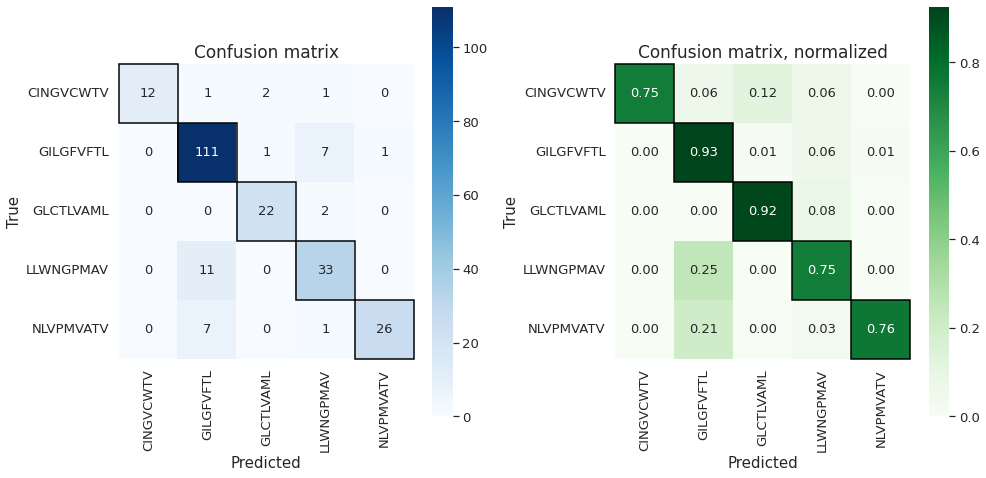

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

Plot metrics (per epitope)

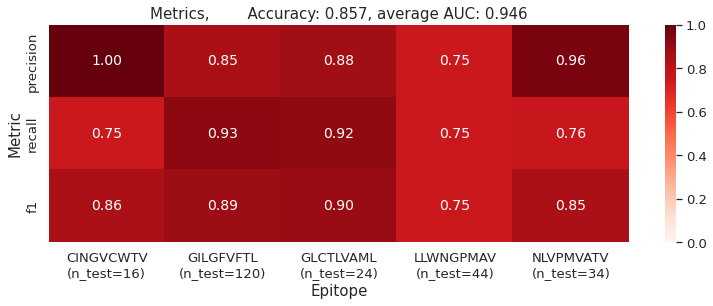

In [ ]:
plt.figure(figsize=(13,4))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])


Plot ROC curves

In [ ]:
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]

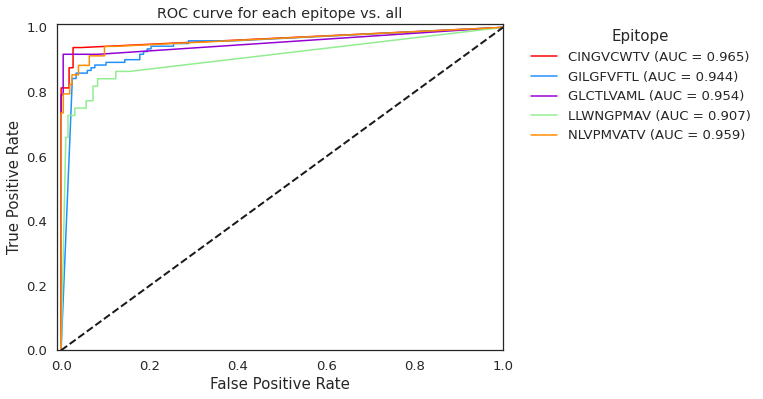

In [ ]:
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope vs. all')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)

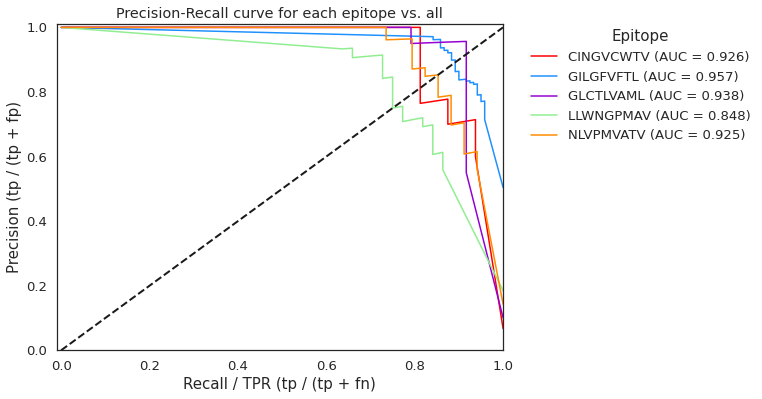

In [ ]:
from sklearn.metrics import precision_recall_curve

# Get precision_recall curve info for each epitope
precision_cur = dict()
recall_cur = dict()
pre_rec_auc = dict()
for i, ep in enumerate(model.classes_):
    precision_cur[ep], recall_cur[ep], _ = precision_recall_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    pre_rec_auc[ep] = auc(recall_cur[ep], precision_cur[ep])

# Plot precision_recall curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(recall_cur[ep], precision_cur[ep], color=color, lw=1.5, label=f'{ep} (AUC = {pre_rec_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall / TPR (tp / (tp + fn)', fontsize=15)
plt.ylabel('Precision (tp / (tp + fp)', fontsize=15)
plt.title('Precision-Recall curve for each epitope vs. all')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)